In [2]:
# 구글 드라이브의 폴더와 구글 코랩 폴더 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 현재 경로 확인
!pwd

/content


In [4]:
# drive/My Drive/Colab Notebooks 경로로 변경
%cd drive/My\ Drive/Colab\ Notebooks\

/content/drive/My Drive/Colab Notebooks


## Faster R-CNN

```
Fast R-CNN에서 Selective search를 제거하고 대신에 Region proposal network를 통해 대략적인 물체의 위치를 찾는 방식을 사용한다 
처음 부터 끝까지 CNN안에서 작동하기 때문에 Fast R-CNN보다 훨씬 더 빠르다 
```

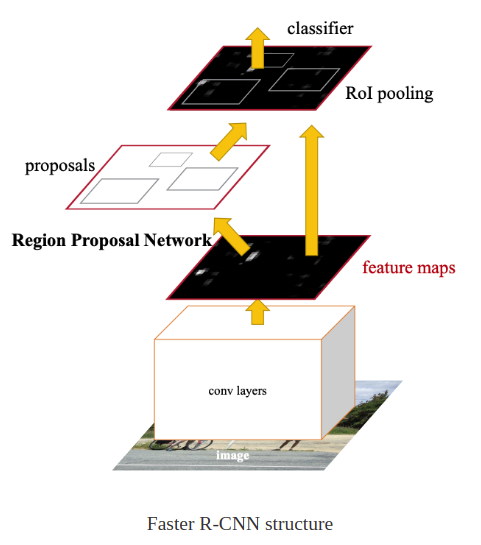

## Region Proposal

> 물체가 있을 만한 위치를 찾는 방법 

```python
1. Selective search 
- 색상, 질감, 크기 등을 기준으로 유사도를 비교하여 영역들을 통합한다 
이때 threshold에 따라서 후보 영역들을 만들어 낸다 (selective search 논문에서는 2000개의 후보영역을 만들어냈다) 
2. Edge boxes
- Gradient magnitude와 gradient orientation을 사용하여 edge group을 표현하고, 
이를 이용하여 bounding box score를 찾아내는 방법 
3. Region proposal network 
```

## Region proposal network

> 원본 이미지에서 region proposals를 추출하는 네트워크 <br>
> RPN은 각 위치에서 객체의 경계와 IOU점수를 동시에 예측하는 fully connected convolution network이다 

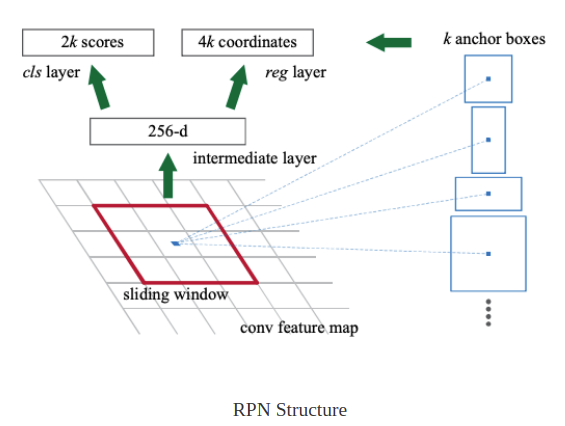

In [5]:
import tensorflow as tf 
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [6]:
img = tf.keras.utils.get_file('zebra.jpg', 'https://i.imgur.com/XjeiRMV.jpg')

188416/179968 [===============================] - 0s 0us/step


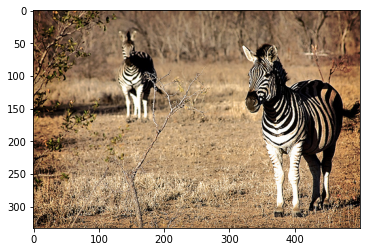

In [80]:
im = cv2.imread(img)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)

In [81]:
im_ = im.copy()

In [82]:
rec1 = cv2.rectangle(im_, (120,25),(200,165), color=(255,0,0), thickness=2)
rec2 = cv2.rectangle(im_, (300,50),(480,320), color=(255,0,0), thickness=2)

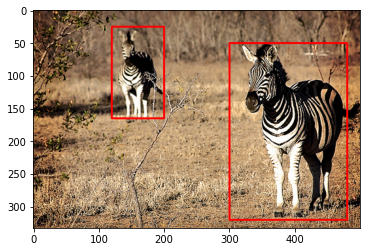

In [83]:
plt.imshow(im_)

In [84]:
h = w = 800

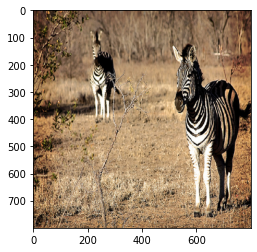

In [85]:
plt.imshow(cv2.resize(im, (w,h), interpolation=cv2.INTER_NEAREST))

In [86]:
im_.shape

(333, 500, 3)

In [87]:
800/333, 800/500

(2.4024024024024024, 1.6)

In [88]:
im_r = cv2.resize(im, (h,w))
im_r_ = im_r.copy()

In [20]:
x = np.array([120,25,200,165])
y = np.array([300,50,480,320])

In [89]:
# mapping 
x[0] = int(x[0]*(w/im.shape[1])) # 비율 곱 
x[1] = int(x[1]*(h/im.shape[0]))
x[2] = int(x[2]*(w/im.shape[1]))
x[3] = int(x[3]*(h/im.shape[0]))

y[0] = int(y[0]*(w/im.shape[1]))
y[1] = int(y[1]*(h/im.shape[0]))
y[2] = int(y[2]*(w/im.shape[1]))
y[3] = int(y[3]*(h/im.shape[0]))

In [22]:
rec1 = cv2.rectangle(im_r_, (x[0],x[1]),(x[2],x[3]), color=(255,0,0), thickness=2)
rec2 = cv2.rectangle(im_r_, (y[0],y[1]),(y[2],y[3]), color=(255,0,0), thickness=2)

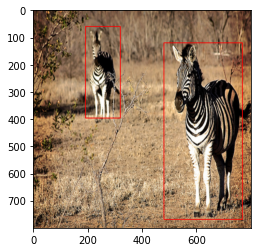

In [23]:
plt.imshow(im_r_)

In [24]:
vgg = tf.keras.applications.VGG16(include_top=False)

58900480/58889256 [==============================] - 1s 0us/step


In [25]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [26]:
# 800x800 이미지가 최종적으로 25x25로 줄어든다 (convolutional layer를 통과하기 때문에)
for i in vgg.layers:
  output = tf.keras.models.Model(vgg.input, i.output)
  print(output(im_r_[tf.newaxis]).shape)

(1, 800, 800, 3)
(1, 800, 800, 64)
(1, 800, 800, 64)
(1, 400, 400, 64)
(1, 400, 400, 128)
(1, 400, 400, 128)
(1, 200, 200, 128)
(1, 200, 200, 256)
(1, 200, 200, 256)
(1, 200, 200, 256)
(1, 100, 100, 256)
(1, 100, 100, 512)
(1, 100, 100, 512)
(1, 100, 100, 512)
(1, 50, 50, 512)
(1, 50, 50, 512)
(1, 50, 50, 512)
(1, 50, 50, 512)
(1, 25, 25, 512)


In [27]:
# 몇번째 layer까지 사용하는지에 따라 mapping하는 이미지 비율이 달라진다
backbone = tf.keras.models.Model(vgg.input, vgg.layers[17].output) # Faster R-CNN 논문에서는 17번째 layer까지 사용했다

In [28]:
backbone(im_r_[tf.newaxis]).shape

TensorShape([1, 50, 50, 512])

In [29]:
# from skimage.util import view_as_blocks, view_as_windows 겹쳐서 자르기, 겹치지 않고 자르기  

In [30]:
# 800x800 => 50x50  :   16x16이미지가 1x1로 표현된다는 의미이다                   

In [31]:
x = np.arange(8,800,16)
y = np.arange(8,800,16)
cl = np.array(np.meshgrid(x,y)).T.reshape(-1,2) # 중점들 모음 array 

In [32]:
cl.shape

(2500, 2)

In [33]:
im_r = cv2.resize(im, (h,w))
im_r_ = im_r.copy()

In [34]:
for i in range(2500):
  cv2.circle(im_r_, (cl[i,0],cl[i,1]), 1, (255,0,0), thickness=2)

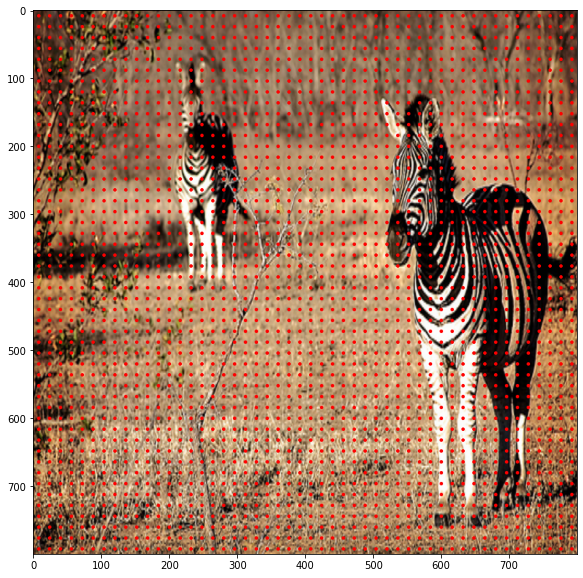

In [35]:
plt.figure(figsize=(10,10))
plt.imshow(im_r_) # 50x50 영역을 표기하기 위한 점들 

In [36]:
ratio = [0.5,1,2]
scale = [8,16,32]
al = np.zeros((22500,4)) # 50x50x9개 그림을 그릴 수 있다 
count = 0

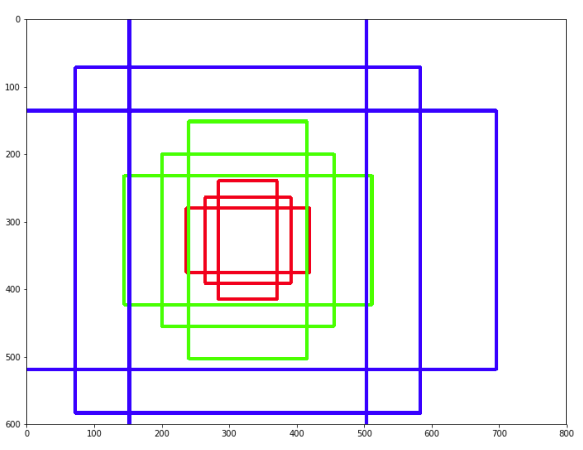

```
같은 색 영역들은 모양만 다르고 가능한 영역의 크기들은 근접하게 만들어야 한다 
```

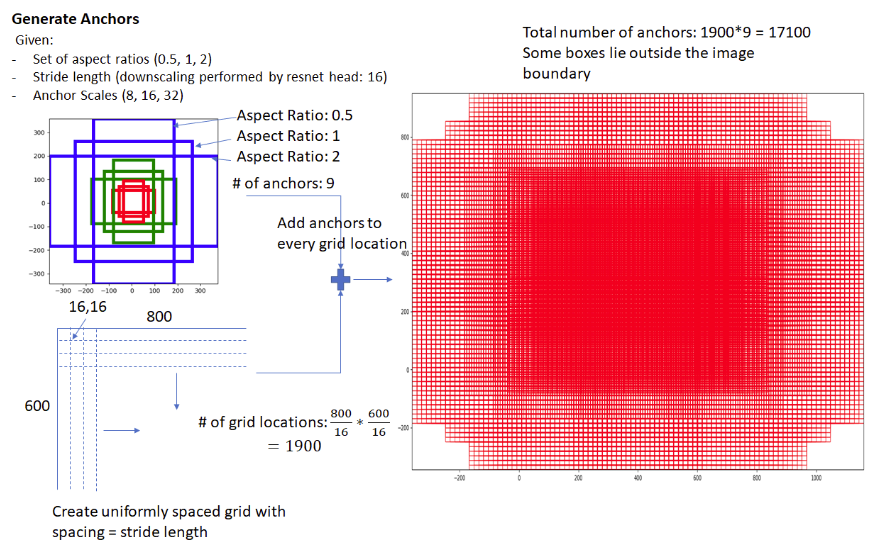

```
(위 그림의 예시는 800x600 이미지에 대한 anchor boxes를 만든 것이다) 

800x800 이미지에 대한 anchor box의 중점은 800/16 * 800/16 = 2500 이고, 
중점당 anchor box의 개수가 9개 이므로 2500*9 = 22500 총 22500개의 anchor boxes가 생성이 된다 
```

In [37]:
for i in cl:
  cx, cy = i[0], i[1]
  for r in ratio:
    for s in scale:
      h = pow(pow(s,2)/r,0.5) # 지수를 사용하고 루트를 씌우는 이유 : numerical stability때문에 
      w = h*r
      h *= 16 # 1칸에 16이기 때문에?
      w *= 16 
      xmin = cx-0.5*w
      ymin = cy-0.5*h
      xmax = cx+0.5*w
      ymax = cy+0.5*h
      al[count] = [xmin,ymin,xmax,ymax]
      count += 1 

In [38]:
al

array([[ -37.254834  ,  -82.50966799,   53.254834  ,   98.50966799],
       [ -82.50966799, -173.01933598,   98.50966799,  189.01933598],
       [-173.01933598, -354.03867197,  189.01933598,  370.03867197],
       ...,
       [ 701.49033201,  746.745166  ,  882.50966799,  837.254834  ],
       [ 610.98066402,  701.49033201,  973.01933598,  882.50966799],
       [ 429.96132803,  610.98066402, 1154.03867197,  973.01933598]])

In [93]:
img_ = np.copy(im_r)

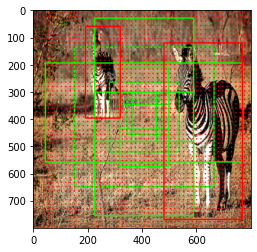

In [94]:
point = 11465
for i in range(point,point+9):
  x_min = int(al[i][0])
  y_min = int(al[i][1])
  x_max = int(al[i][2])
  y_max = int(al[i][3])
  cv2.rectangle(img_, (x_min,y_min),(x_max,y_max),(0,255,0),thickness=4)

for i in range(2500):
  cv2.circle(img_, (cl[i,0],cl[i,1]), 1, (255,0,0), thickness=2)

x = np.array([120,25,200,165])
y = np.array([300,50,480,320])

x[0] = int(x[0]*(w/im.shape[1])) 
x[1] = int(x[1]*(h/im.shape[0]))
x[2] = int(x[2]*(w/im.shape[1]))
x[3] = int(x[3]*(h/im.shape[0]))

y[0] = int(y[0]*(w/im.shape[1]))
y[1] = int(y[1]*(h/im.shape[0]))
y[2] = int(y[2]*(w/im.shape[1]))
y[3] = int(y[3]*(h/im.shape[0]))

rec1 = cv2.rectangle(img_, (x[0],x[1]),(x[2],x[3]), color=(255,0,0), thickness=3)
rec2 = cv2.rectangle(img_, (y[0],y[1]),(y[2],y[3]), color=(255,0,0), thickness=3)

plt.imshow(img_)

```
물체를 인식하는 사각형 하나와 22500개의 anchor box가 겹치는 부분을 구한다 
그렇게 해서 계산된 IOU값을 구하고 가장 많이 겹치는 anchor box를 구한다 
논문에서는 IOU가 0.7보다 높은 것을 사용하고 0.3 보다 작은 것은 없는 것으로 판단한다
```

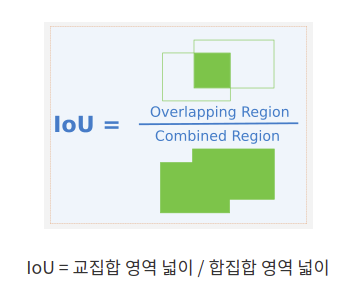

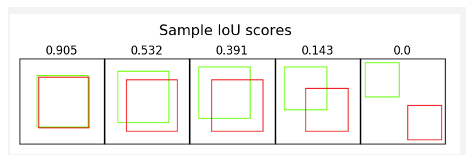